In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize
sns.set()

In [3]:
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01', actions=False)
data.drop(['Open','High','Low','Volume'],inplace=True, axis = 1)
data = data.droplevel(0,axis=1).resample('W').last()

[*********************100%***********************]  9 of 9 completed


In [4]:
# return, cov
ret = data.pct_change().dropna()
ret_vect = ret.mean() * 52
cov_mat = ret.cov() *52

In [5]:
ret_vect

Ticker
XLB    0.107782
XLE    0.092247
XLF    0.127194
XLI    0.138481
XLK    0.185684
XLP    0.112418
XLU    0.112574
XLV    0.136683
XLY    0.156053
dtype: float64

In [6]:
cov_mat

Ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Ticker,,,,,,,,,
XLB,0.042764,0.039969,0.036538,0.035684,0.028742,0.016584,0.018523,0.021568,0.031266
XLE,0.039969,0.073069,0.040269,0.037853,0.025058,0.016382,0.018299,0.020707,0.028218
XLF,0.036538,0.040269,0.045346,0.036723,0.028338,0.017353,0.018541,0.022215,0.032090
XLI,0.035684,0.037853,0.036723,0.037952,0.029164,0.017694,0.019442,0.021576,0.031615
XLK,0.028742,0.025058,0.028338,0.029164,0.038145,0.016018,0.015278,0.020608,0.032813
XLP,0.016584,0.016382,0.017353,0.017694,0.016018,0.017146,0.015616,0.014652,0.017051
XLU,0.018523,0.018299,0.018541,0.019442,0.015278,0.015616,0.030579,0.015710,0.017617
XLV,0.021568,0.020707,0.022215,0.021576,0.020608,0.014652,0.015710,0.024159,0.021024
XLY,0.031266,0.028218,0.032090,0.031615,0.032813,0.017051,0.017617,0.021024,0.038677


In [7]:
pal = sns.color_palette('Spectral', len(tickers))

## Market Capital Weight

In [8]:
cap_list = []
for ticker in tickers:
    market_cap = yf.Ticker(ticker).info['totalAssets'] #etf's size = 'totalAssets'
    cap_list.append(market_cap)

In [9]:
caps = cap_list
caps_df = pd.Series(caps, index=tickers)
market_weights_df = caps_df / caps_df.sum()
market_weights_df

XLB    0.020580
XLE    0.136695
XLF    0.167543
XLI    0.072532
XLK    0.253072
XLP    0.062518
XLU    0.063164
XLV    0.155001
XLY    0.068896
dtype: float64

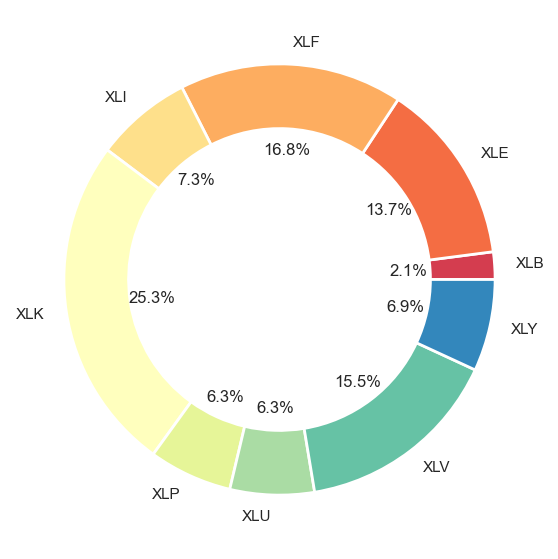

In [10]:
plt.figure(figsize=(7, 7))
wedgeprops = {'width':0.3, 'edgecolor':'w', 'linewidth':2}
plt.pie(market_weights_df, labels=market_weights_df.index, autopct='%.1f%%', wedgeprops=wedgeprops, colors=pal)
plt.show()

In [11]:
# 시장 포트폴리오 수익률 평균 및 분산
mkt_port_ret = ret_vect.multiply(market_weights_df.values).sum()
mkt_port_var = np.matmul(market_weights_df.values.reshape(len(market_weights_df)).T,np.matmul(cov_mat.values, market_weights_df.values.reshape(len(market_weights_df))))

print(mkt_port_ret, mkt_port_var)

0.13925021890333159 0.027162586481005835


In [12]:
# 위험회피계수
mkt_lambda = mkt_port_ret / np.sqrt(mkt_port_var)
print(mkt_lambda)

0.8449097573394798


## BLM- Reverse Engineering

In [13]:
# 균형기대수익률
pi = np.dot(np.dot(mkt_lambda, cov_mat), market_weights_df)
pi_df = pd.Series(pi, index=tickers)
pi_df

XLB    0.025374
XLE    0.028709
XLF    0.026698
XLI    0.025391
XLK    0.023619
XLP    0.013797
XLU    0.015058
XLV    0.017640
XLY    0.024144
dtype: float64

### 투자자 전망과 기대수익률 그리고 전망의 불확실성 계산

In [14]:
# 투자자 전망
# 3 개의 전망. 
Q = np.array([0.0925, 0.005, 0.055]) # [전망1수치, 전망2수치, 전망3수치]
P = [[0, 0, 0, 0, 0, 0, 1, 0, 0], # 절대적 첫번째 전망 : XLU가 0.0925 더 잘나갈것이다 
     [0, 0, 1, -1, 0, 0, 0, 0, 0], # 상대적 두번쨰 전망 : XLF가 XLI보다 0.005 더 잘나갈것이다. 
     [0, 0, 0, 0, 0, 0, 0, 1, 0]] # XLV 0.055 가 더 잘나갈것이다. 

# 위험조정상수
tau = 1 / len(data) * 52

# 투자자 전망의 불확실성 계산
omega = np.diag(np.diag(np.dot(np.dot(np.dot(tau, P), cov_mat), np.transpose(P)))) 

In [15]:
omega
# 3가지 전망의 불확실성 정도

array([[0.00207315, 0.        , 0.        ],
       [0.        , 0.00066798, 0.        ],
       [0.        , 0.        , 0.00163789]])

## BLM Model

In [16]:
# 투자자 전망과 합쳐진 균형초과수익률 계산
term1 = np.linalg.inv(np.dot(tau, cov_mat))
term2 = np.dot(np.dot(np.transpose(P), np.linalg.inv(omega)), P)
term3 = np.dot(np.linalg.inv(np.dot(tau, cov_mat)), pi)
term4 = np.dot(np.dot(np.transpose(P), np.linalg.inv(omega)), Q)

# 블랙-리터만 모형에 기반한 사후 분포
bl_cov_mat = np.linalg.inv(term1 + term2)
bl_ret_vec = np.dot(bl_cov_mat, (term3 + term4))

In [21]:
bl_cov_mat

array([[0.00208414, 0.00191559, 0.00162382, 0.0015968 , 0.00120811,
        0.00053076, 0.00042739, 0.00062046, 0.00133226],
       [0.00191559, 0.004171  , 0.00185643, 0.00177595, 0.0009877 ,
        0.00053574, 0.00043276, 0.00058815, 0.00114807],
       [0.00162382, 0.00185643, 0.0019748 , 0.0016844 , 0.00118882,
        0.00058064, 0.00043645, 0.00063152, 0.00136056],
       [0.0015968 , 0.00177595, 0.0016844 , 0.00172747, 0.00122037,
        0.00059151, 0.00045701, 0.00061538, 0.00134663],
       [0.00120811, 0.0009877 , 0.00118882, 0.00122037, 0.00189828,
        0.00054868, 0.00031531, 0.00061859, 0.00150615],
       [0.00053076, 0.00053574, 0.00058064, 0.00059151, 0.00054868,
        0.0007184 , 0.00040071, 0.00039409, 0.00058269],
       [0.00042739, 0.00043276, 0.00043645, 0.00045701, 0.00031531,
        0.00040071, 0.00094085, 0.00029153, 0.00039963],
       [0.00062046, 0.00058815, 0.00063152, 0.00061538, 0.00061859,
        0.00039409, 0.00029153, 0.00074353, 0.00060956],


In [22]:
bl_ret_vec

array([0.05564065, 0.05873473, 0.05901195, 0.05626066, 0.04933322,
       0.03769424, 0.05673924, 0.04557911, 0.05305332])

bl_cov_mat, bl_ret_vec 를 MVO에 넣어

In [17]:
# MVO 모델 가중치 산출 함수
def get_msr_weights(er, cov):

    # 자산개수
    noa = er.shape[0]

    # 가중치 초기값
    init_guess = np.repeat(1/noa, noa)

    # 자산 가중치 상하한
    bounds = ((0.0, 1.0), ) * noa

    # 레버리지 불가 제약조건
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1}

    # 목적함수
    def neg_sharpe(weights, er, cov):
        r = weights.T @ er
        vol = np.sqrt(weights.T @ cov @ weights)
        return - r / vol

    # 최적화 수행
    res = minimize(neg_sharpe,
                   init_guess,
                   args=(er, cov),
                   method='SLSQP',
                   constraints=(weights_sum_to_1,),
                   bounds=bounds)
    
    return res.x

In [18]:
# BL 포트폴리오 가중치
bl_weights = get_msr_weights(bl_ret_vec, bl_cov_mat)

# BL 포트폴리오 수익률
bl_ret = np.dot(bl_weights, bl_ret_vec)

# BL 포트폴리오 변동성
bl_vol = np.sqrt(np.dot(bl_weights.T, np.dot(bl_cov_mat, bl_weights)))


In [19]:
# BL 포트폴리오 수익률과 변동성
print(bl_ret, bl_vol)

0.052268064197078586 0.02404497143855171


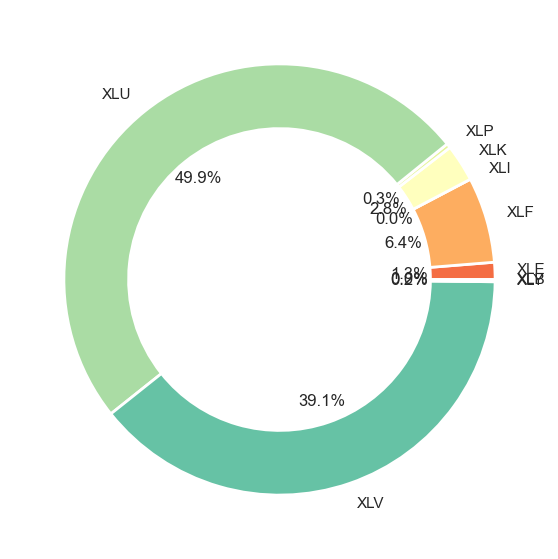

In [20]:
# 블랙-리터만 투자 가중치 데이터프레임
bl_weights_df = pd.Series(bl_weights, index=tickers)

# 파이차트 시각화
plt.figure(figsize=(7, 7))
wedgeprops = {'width':0.3, 'edgecolor':'w', 'linewidth':2}
plt.pie(bl_weights_df, labels=bl_weights_df.index, autopct='%.1f%%', wedgeprops=wedgeprops, colors=pal)
plt.show()

In [ ]:
# 투자자 뷰 반영